# Optymizacja Portfolio - Programowanie Liniowe

## Opis problemu

Jako doradca finansowy dysponuję kwotą **100,000 ZŁ** do zainwestowania. Celem inwestycji jest maksymalizacja oczekiwanego zwrotu mając na uwadze odpowiedni poziom ryzyka, co opisane będzie w założeniach inwestycyjnych.

Główne czynniki które znajdują się w poniższej analizie:
- Optymalizacja wielozadaniowa (zwrot vs. ryzyko)
- Rózne typy ograniczeń (ryzyko, płynność, dywersyfikacja)


In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import matplotlib.pyplot as plt

## Opcje inwestycyjne

Wybrałem 10 różnych instrumentów inwestycyjnych które różnią się oczekiwanym zwrotem, poziomem ryzyka i płynnością.

In [3]:
assets = [
    "Polskie Obligacje Skarbowe",
    "Polskie Blue-Chip (WIG30)",
    "US S&P 500 ETF",
    "ETF Rynków Wschodzących",
    "ETF Spółek Technologicznych",
    "Nieruchomości (REIT)",
    "Obligacje Korporacyjne",
    "ETF Złoto/Surowce",
    "ETF Kryptowaluty",
    "ETF Dywidendowych Arystokratów"
]

expected_returns = np.array([
    4.5,   # Polskie Obligacje Skarbowe - 10-letnie polskie obligacje ~4-5%
    8.5,   # Polskie Blue-Chip (WIG30) - Średnia historyczna ~7-10%
    9.0,   # US S&P 500 ETF - Długoterminowa średnia historyczna ~9-10%
    6.5,   # ETF Rynków Wschodzących - Bardziej zmienne, skorygowane w dół
    11.0,  # ETF Spółek Technologicznych - Wyższe niż S&P, ale bardziej realistyczne niż 18%
    7.0,   # Nieruchomości (REIT) - Typowe zwroty REIT ~6-8%
    5.0,   # Obligacje Korporacyjne - Klasa inwestycyjna ~4.5-5.5%
    5.5,   # ETF Złoto/Surowce - Historycznie ~5-6% z zabezpieczeniem przed inflacją
    15.0,  # ETF Kryptowaluty - Nadal wysokie ryzyko/nagroda, ale bardziej realistyczne niż 25%
    7.5    # ETF Dywidendowych Arystokratów - Stabilni płatnicy dywidend ~7-8%
])

# Poziomy ryzyka: 0=Bardzo niskie, 1=Niskie, 2=Średnio-niskie, 3=Srednie, 4=Wysokie, 5=Bardzo wysokie
risk_levels = np.array([0, 3, 3, 4, 5, 2, 1, 3, 5, 2])

# Płynność: 0=Średnia, 1=Wysoka
liquidity = np.array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1])

# Kapitał
total_capital = 100000  # PLN

# Liczba insturmentów
n = len(assets)

print(f"Kapitał całkowity: {total_capital:,} PLN")
print(f"Liczba opcji inwestycyjnych: {n}\n")
print("Investment Options:")
risk_names = ["Bardzo niskie", "Niskie", "Średnio-niskie", "Srednie", "Wysokie", "Bardzo wysokie"]
liq_names = ["Średnia", "Wysoka"]
for i, asset in enumerate(assets):
    print(f"  {i+1:2d}. {asset:30s} | Zwrot: {expected_returns[i]:5.1f}% | "
          f"Ryzyko: {risk_names[risk_levels[i]]:15s} | Płynność: {liq_names[liquidity[i]]}")

Kapitał całkowity: 100,000 PLN
Liczba opcji inwestycyjnych: 10

Investment Options:
   1. Polskie Obligacje Skarbowe     | Zwrot:   4.5% | Ryzyko: Bardzo niskie   | Płynność: Wysoka
   2. Polskie Blue-Chip (WIG30)      | Zwrot:   8.5% | Ryzyko: Srednie         | Płynność: Wysoka
   3. US S&P 500 ETF                 | Zwrot:   9.0% | Ryzyko: Srednie         | Płynność: Wysoka
   4. ETF Rynków Wschodzących        | Zwrot:   6.5% | Ryzyko: Wysokie         | Płynność: Średnia
   5. ETF Spółek Technologicznych    | Zwrot:  11.0% | Ryzyko: Bardzo wysokie  | Płynność: Wysoka
   6. Nieruchomości (REIT)           | Zwrot:   7.0% | Ryzyko: Średnio-niskie  | Płynność: Średnia
   7. Obligacje Korporacyjne         | Zwrot:   5.0% | Ryzyko: Niskie          | Płynność: Wysoka
   8. ETF Złoto/Surowce              | Zwrot:   5.5% | Ryzyko: Srednie         | Płynność: Wysoka
   9. ETF Kryptowaluty               | Zwrot:  15.0% | Ryzyko: Bardzo wysokie  | Płynność: Średnia
  10. ETF Dywidendowych Arystok

## Klasyfikacja Aktywów

Klasyfikujemy aktywa według różnych kategorii w celu określenia ograniczeń.

In [4]:
is_tech = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])  # Technologie
is_bond = np.array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0])  # Obligacje
is_international = np.array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1])  # Międzynarodowe
is_esg = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])  # REIT - środowiskowy, społeczny i ład korporacyjny (ESG)
is_crypto = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])  # Kryptowaluty
is_inflation_protected = np.array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])  # Złoto/Surowce + REIT

# Aktywa bardzo wysokiego ryzyka
is_very_high_risk = (risk_levels == 5).astype(int)
# Aktywa niskiego ryzyka
is_low_risk = (risk_levels <= 1).astype(int)
# Aktywa o wysokiej płynności
is_high_liquidity = (liquidity == 1).astype(int)
# Aktywa o średniej płynności
is_medium_liquidity = (liquidity == 0).astype(int)

## Formuły Matematyczne

### Zmienne decyzyjne
Niech $x_i$ reprezentuje kwotę (w PLN) zainwestowaną w aktywo $i$, gdzie $i = 1, 2, ..., 10$.

### Funkcja celu
Maksymalizacja oczekiwanej stopy zwrotu z portfela:

$$
\max \sum_{i=1}^{10} r_i \cdot x_i
$$

gdzie $r_i$ to oczekiwana stopa zwrotu z aktywu $i$.

Ponieważ `linprog` minimalizuje, używamy:
$$
\min \sum_{i=1}^{10} -r_i \cdot x_i
$$

### Ograniczenia

**1. Zarządzanie ryzykiem:**
- Maksymalnie 30% w dowolnym pojedynczym aktywie: $x_i \leq 0,30 \times \text{kapitał}$ dla wszystkich $i$
- Maksymalnie 40% w aktywach o bardzo wysokim ryzyku: $\sum_{i \in \text{VeryHighRisk}} x_i \leq 0,40 \times \text{kapitał}$
- Minimum 20% w aktywach o niskim/bardzo niskim ryzyku: $\sum_{i \in \text{LowRisk}} x_i \geq 0,20 \times \text{kapitał}$

**2. Płynność:**
- Minimum 50% w aktywach o wysokiej płynności: $\sum_{i \in \text{HighLiq}} x_i \geq 0,50 \times \text{kapitał}$
- Maksymalnie 20% w aktywach o średniej płynności: $\sum_{i \in \text{MediumLiq}} x_i \leq 0,20 \times \text{kapitał}$

**3. Dywersyfikacja sektorowa:**
- Maksymalnie 25% w sektorze technologicznym: $\sum_{i \in \text{Technologia}} x_i \leq 0,25 \times \text{kapitał}$
- Maksymalnie 30% w sektorze obligacji: $\sum_{i \in \text{Obligacje}} x_i \leq 0,30 \times \text{kapitał}$
- Minimum 10% w sektorze międzynarodowym: $\sum_{i \in \text{Międzynarodowy}} x_i \geq 0,10 \times \text{kapitał}$

**4. Preferencje klienta:**
- Minimum 5% w ESG: $\sum_{i \in \text{ESG}} x_i \geq 0,05 \times \text{kapitał}$
- Maksymalnie 10% w kryptowalutach: $\sum_{i \in \text{Krypto}} x_i \leq 0,10 \times \text{kapitał}$
- Minimum 15% w zabezpieczeniu przed inflacją: $\sum_{i \in \text{InflationProt}} x_i \geq 0,15 \times \text{kapitał}$

**5. Ograniczenia kapitałowe:**
- Inwestuj co najmniej 95%: $\sum_{i=1}^{10} x_i \geq 0,95 \times \text{kapitał}$
- Nie przekraczaj kapitału: $\sum_{i=1}^{10} x_i \leq \text{kapitał}$
- Minimalny docelowy zwrot: $\sum_{i=1}^{10} r_i \cdot x_i \geq 0,10 \times \text{kapitał}$

**6. Nieujemność:**
- $x_i \geq 0$ dla wszystkich $i$


## Budowanie macierzy ograniczeń

Konstruujemy macierze ograniczeń $A_{ub}$ i $b_{ub}$ dla ograniczeń nierównościowych w postaci $A_{ub} \cdot x \leq b_{ub}$.

In [5]:
# Cel: Maksymalizacja oczekiwanego zwrotu
c = -expected_returns / 100

# Inicjalizacja macierzy ograniczeń
A_ub = []
b_ub = []

# Ograniczenie 1: Maksymalnie 30% w dowolnym pojedynczym zasobie
print("1. Limity poszczególnych aktywów (maks. 30% każdy)")
for i in range(n):
    constraint = np.zeros(n)
    constraint[i] = 1
    A_ub.append(constraint)
    b_ub.append(0.30 * total_capital)

# Ograniczenie 2: Maksymalnie 40% w aktywach bardzo wysokiego ryzyka
print("2. Maksymalnie 40% w aktywach bardzo wysokiego ryzyka")
A_ub.append(is_very_high_risk)
b_ub.append(0.45 * total_capital)

# Ograniczenie 3: Minimum 20% w aktywach o niskim lub bardzo niskim ryzyku
print("3. Minimum 20% w aktywach o niskim/bardzo niskim ryzyku")
A_ub.append(-is_low_risk)
b_ub.append(-0.20 * total_capital)

# Ograniczenie 4: Minimum 50% w aktywach o wysokiej płynności
print("4. Minimum 50% w aktywach o wysokiej płynności")
A_ub.append(-is_high_liquidity)
b_ub.append(-0.50 * total_capital)

# Ograniczenie 5: Maksymalnie 20% w aktywach o średniej płynności
print("5. Maksymalnie 20% w aktywach o średniej płynności")
A_ub.append(is_medium_liquidity)
b_ub.append(0.20 * total_capital)

# Ograniczenie 6: Maksymalnie 25% w Technologii
print("6. Maksymalnie 25% w Technologii")
A_ub.append(is_tech)
b_ub.append(0.3 * total_capital)

# Ograniczenie 7: Maksymalnie 30% w obligacjach
print("7. Maksymalnie 30% w obligacjach")
A_ub.append(is_bond)
b_ub.append(0.30 * total_capital)

# Ograniczenie 8: Minimum 10% ekspozycji międzynarodowej
print("8. Minimum 10% w aktywach międzynarodowych")
A_ub.append(-is_international)
b_ub.append(-0.15 * total_capital)

# Ograniczenie 9: Minimum 5% w inwestycjach przyjaznych ESG
print("9. Minimum 5% w inwestycjach przyjaznych ESG")
A_ub.append(-is_esg)
b_ub.append(-0.05 * total_capital)

# Ograniczenie 10: Maksymalnie 10% w kryptowalucie
print("10. Maksymalnie 10% w kryptowalucie")
A_ub.append(is_crypto)
b_ub.append(0.12 * total_capital)

# Ograniczenie 11: Minimum 15% w aktywach chronionych przed inflacją
print("11. Minimum 15% w aktywach chronionych przed inflacją")
A_ub.append(-is_inflation_protected)
b_ub.append(-0.15 * total_capital)

# Ograniczenie 12: Zainwestuj co najmniej 95% kapitału
print("12. Zainwestuj co najmniej 95% kapitału")
A_ub.append(-np.ones(n))
b_ub.append(-0.90 * total_capital)

# Ograniczenie 13: Nie przekraczaj całkowitego kapitału
print("13. Nie przekraczaj całkowitego kapitału")
A_ub.append(np.ones(n))
b_ub.append(total_capital)

# Ograniczenie 14: Minimalny oczekiwany zwrot 10%
print("14. Minimalny oczekiwany zwrot 10% rocznie")
A_ub.append(-expected_returns / 100 )
b_ub.append(-0.08 * total_capital)

# Konwertuj na tablice numpy
A_ub = np.array(A_ub)
b_ub = np.array(b_ub)

# Granice: każdy składnik aktywów pomiędzy 0 a total_capital
bounds = [(0, total_capital) for _ in range(n)]

print(f"\nCałkowita liczba ograniczeń: {len(b_ub)}")
print(f"Kształt macierzy ograniczeń: {A_ub.shape}")

1. Limity poszczególnych aktywów (maks. 30% każdy)
2. Maksymalnie 40% w aktywach bardzo wysokiego ryzyka
3. Minimum 20% w aktywach o niskim/bardzo niskim ryzyku
4. Minimum 50% w aktywach o wysokiej płynności
5. Maksymalnie 20% w aktywach o średniej płynności
6. Maksymalnie 25% w Technologii
7. Maksymalnie 30% w obligacjach
8. Minimum 10% w aktywach międzynarodowych
9. Minimum 5% w inwestycjach przyjaznych ESG
10. Maksymalnie 10% w kryptowalucie
11. Minimum 15% w aktywach chronionych przed inflacją
12. Zainwestuj co najmniej 95% kapitału
13. Nie przekraczaj całkowitego kapitału
14. Minimalny oczekiwany zwrot 10% rocznie

Całkowita liczba ograniczeń: 23
Kształt macierzy ograniczeń: (23, 10)


## Rozwiązywanie problemu optymalizacji

In [6]:
result = linprog(
    c=c,
    A_ub=A_ub,
    b_ub=b_ub,
    bounds=bounds,
    method='highs'
)

print(result)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -9115.0
              x: [ 0.000e+00  0.000e+00  2.300e+04  0.000e+00  3.000e+04
                   8.000e+03  2.000e+04  7.000e+03  1.200e+04  0.000e+00]
            nit: 5
          lower:  residual: [ 0.000e+00  0.000e+00  2.300e+04  0.000e+00
                              3.000e+04  8.000e+03  2.000e+04  7.000e+03
                              1.200e+04  0.000e+00]
                 marginals: [ 5.000e-03  5.000e-03  0.000e+00  4.000e-02
                              0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  1.500e-02]
          upper:  residual: [ 1.000e+05  1.000e+05  7.700e+04  1.000e+05
                              7.000e+04  9.200e+04  8.000e+04  9.300e+04
                              8.800e+04  1.000e+05]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                    

## Analiza otrzymanych wyników

In [7]:
if result.success:
    print("\n" + "="*80)
    print("OPTYMALIZACJA UDANA")
    print("="*80)
    
    # Kalkulowanie metryk stworzonego portfolio
    optimal_allocation = result.x
    total_invested = np.sum(optimal_allocation)
    expected_portfolio_return = np.sum(optimal_allocation * expected_returns / 100)
    portfolio_return_pct = expected_portfolio_return / total_invested * 100
    
    print(f"\nCałkowita zainwestowana kwota: {total_invested:,.2f} PLN ({total_invested/total_capital*100:.1f}% kapitału)")
    print(f"Pozostała gotówka: {total_capital - total_invested:,.2f} PLN")
    print(f"\nOczekiwana roczna stopa zwrotu: {expected_portfolio_return:,.2f} PLN")
    print(f"Oczekiwana stopa zwrotu: {portfolio_return_pct:.2f}%")
    
else:
    print("\n" + "="*80)
    print("OPTYMALIZACJA ZAWIODŁA")
    print("="*80)
    print(f"Status: {result.message}")


OPTYMALIZACJA UDANA

Całkowita zainwestowana kwota: 100,000.00 PLN (100.0% kapitału)
Pozostała gotówka: 0.00 PLN

Oczekiwana roczna stopa zwrotu: 9,115.00 PLN
Oczekiwana stopa zwrotu: 9.12%


## Alokacja optymalnego portfolio

In [8]:
if result.success:
    # Tworzenie tablicy alokacji
    allocation_data = []
    for i in range(n):
        if optimal_allocation[i] > 0.01:
            allocation_data.append({
                'Aktywa': assets[i],
                'Kwota (zł)': optimal_allocation[i],
                'Procent (%)': optimal_allocation[i] / total_capital * 100,
                'Oczekiwana stopa zwrotu (zł)': optimal_allocation[i] * expected_returns[i] / 100,
                'Stopa zwrotu (%)': expected_returns[i]
            })
    
    df = pd.DataFrame(allocation_data)
    df = df.sort_values('Kwota (zł)', ascending=False)
    
    print("\n" + "="*80)
    print("ALOKACJA OPTYMALNEGO PORTFOLIO")
    print("="*80 + "\n")
    print(df.to_string(index=False))


ALOKACJA OPTYMALNEGO PORTFOLIO

                     Aktywa  Kwota (zł)  Procent (%)  Oczekiwana stopa zwrotu (zł)  Stopa zwrotu (%)
ETF Spółek Technologicznych     30000.0         30.0                        3300.0              11.0
             US S&P 500 ETF     23000.0         23.0                        2070.0               9.0
     Obligacje Korporacyjne     20000.0         20.0                        1000.0               5.0
           ETF Kryptowaluty     12000.0         12.0                        1800.0              15.0
       Nieruchomości (REIT)      8000.0          8.0                         560.0               7.0
          ETF Złoto/Surowce      7000.0          7.0                         385.0               5.5


## Wizualizacja Portfolio

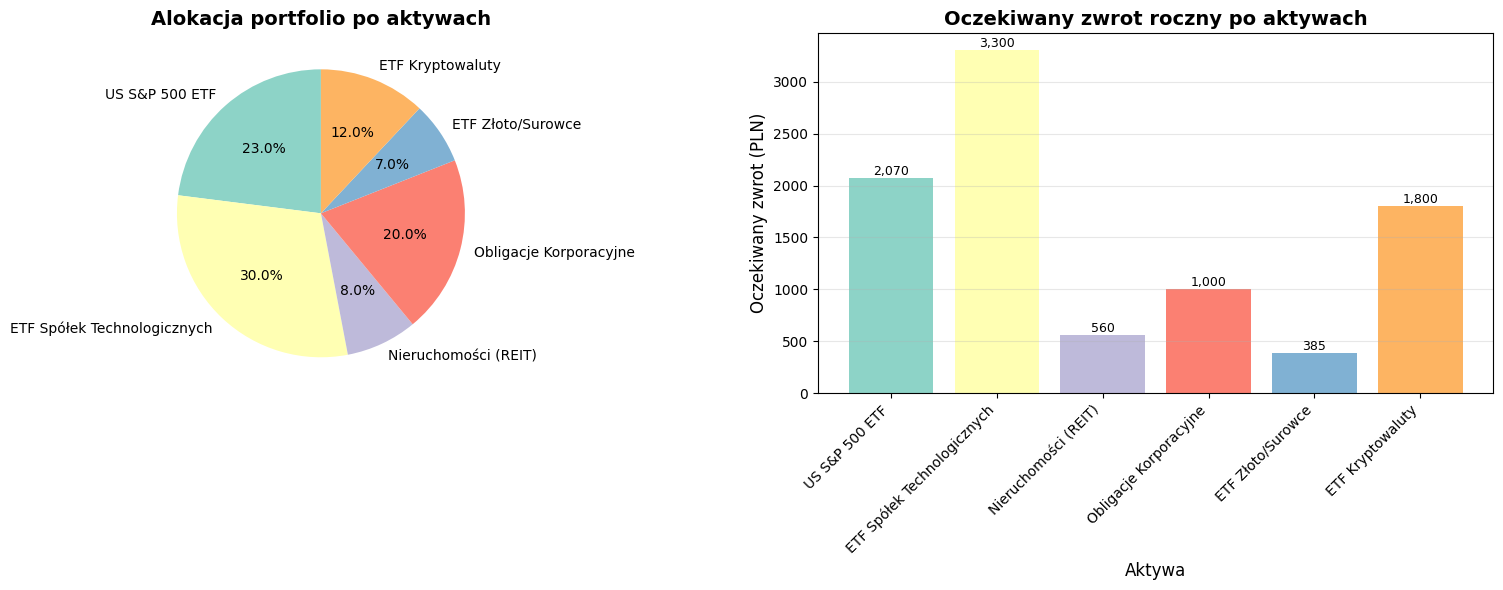

In [9]:
if result.success:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = plt.cm.Set3(range(len(allocation_data)))
    ax1.pie(
        [item['Kwota (zł)'] for item in allocation_data],
        labels=[item['Aktywa'] for item in allocation_data],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )
    ax1.set_title('Alokacja portfolio po aktywach', fontsize=14, fontweight='bold')
    
    # Bar chart of expected returns
    asset_names = [item['Aktywa'] for item in allocation_data]
    returns = [item['Oczekiwana stopa zwrotu (zł)'] for item in allocation_data]
    
    bars = ax2.bar(range(len(returns)), returns, color=colors)
    ax2.set_xlabel('Aktywa', fontsize=12)
    ax2.set_ylabel('Oczekiwany zwrot (PLN)', fontsize=12)
    ax2.set_title('Oczekiwany zwrot roczny po aktywach', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(asset_names)))
    ax2.set_xticklabels(asset_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Podsumowanie składu portfela

In [10]:
if result.success:
    print("\n" + "="*80)
    print("PODSUMOWANIE SKŁADU PORTFELA")
    print("="*80)
    
    very_high_risk_total = np.sum(optimal_allocation * is_very_high_risk)
    low_risk_total = np.sum(optimal_allocation * is_low_risk)
    print(f"\nProfil Ryzyka:")
    print(f"  Aktywa o wysokim ryzyku: {very_high_risk_total:,.2f} PLN ({very_high_risk_total/total_capital*100:.1f}%)")
    print(f"  Aktywa o niskim/bardzo niskim ryzyku: {low_risk_total:,.2f} PLN ({low_risk_total/total_capital*100:.1f}%)")
    
    high_liq_total = np.sum(optimal_allocation * is_high_liquidity)
    med_liq_total = np.sum(optimal_allocation * is_medium_liquidity)
    print(f"\nProfil Płynności:")
    print(f"  Aktywa wysokiej płynności: {high_liq_total:,.2f} PLN ({high_liq_total/total_capital*100:.1f}%)")
    print(f"  Aktywa średniej płynności: {med_liq_total:,.2f} PLN ({med_liq_total/total_capital*100:.1f}%)")

    tech_total = np.sum(optimal_allocation * is_tech)
    bond_total = np.sum(optimal_allocation * is_bond)
    intl_total = np.sum(optimal_allocation * is_international)
    print(f"\nAlokacja ze względu na sektor:")
    print(f"  Technologia: {tech_total:,.2f} PLN ({tech_total/total_capital*100:.1f}%)")
    print(f"  Obligacje: {bond_total:,.2f} PLN ({bond_total/total_capital*100:.1f}%)")
    print(f"  Międzynarodowe: {intl_total:,.2f} PLN ({intl_total/total_capital*100:.1f}%)")
    
    esg_total = np.sum(optimal_allocation * is_esg)
    crypto_total = np.sum(optimal_allocation * is_crypto)
    inflation_total = np.sum(optimal_allocation * is_inflation_protected)
    print(f"\nKategorie Specjalne:")
    print(f"  Przyjazny-ESG: {esg_total:,.2f} PLN ({esg_total/total_capital*100:.1f}%)")
    print(f"  Kryptowaluty: {crypto_total:,.2f} PLN ({crypto_total/total_capital*100:.1f}%)")
    print(f"  Chronione przed inflacją: {inflation_total:,.2f} PLN ({inflation_total/total_capital*100:.1f}%)")


PODSUMOWANIE SKŁADU PORTFELA

Profil Ryzyka:
  Aktywa o wysokim ryzyku: 42,000.00 PLN (42.0%)
  Aktywa o niskim/bardzo niskim ryzyku: 20,000.00 PLN (20.0%)

Profil Płynności:
  Aktywa wysokiej płynności: 80,000.00 PLN (80.0%)
  Aktywa średniej płynności: 20,000.00 PLN (20.0%)

Alokacja ze względu na sektor:
  Technologia: 30,000.00 PLN (30.0%)
  Obligacje: 20,000.00 PLN (20.0%)
  Międzynarodowe: 42,000.00 PLN (42.0%)

Kategorie Specjalne:
  Przyjazny-ESG: 8,000.00 PLN (8.0%)
  Kryptowaluty: 12,000.00 PLN (12.0%)
  Chronione przed inflacją: 15,000.00 PLN (15.0%)


## Wizualizacja Ryzyko vs Zwrot

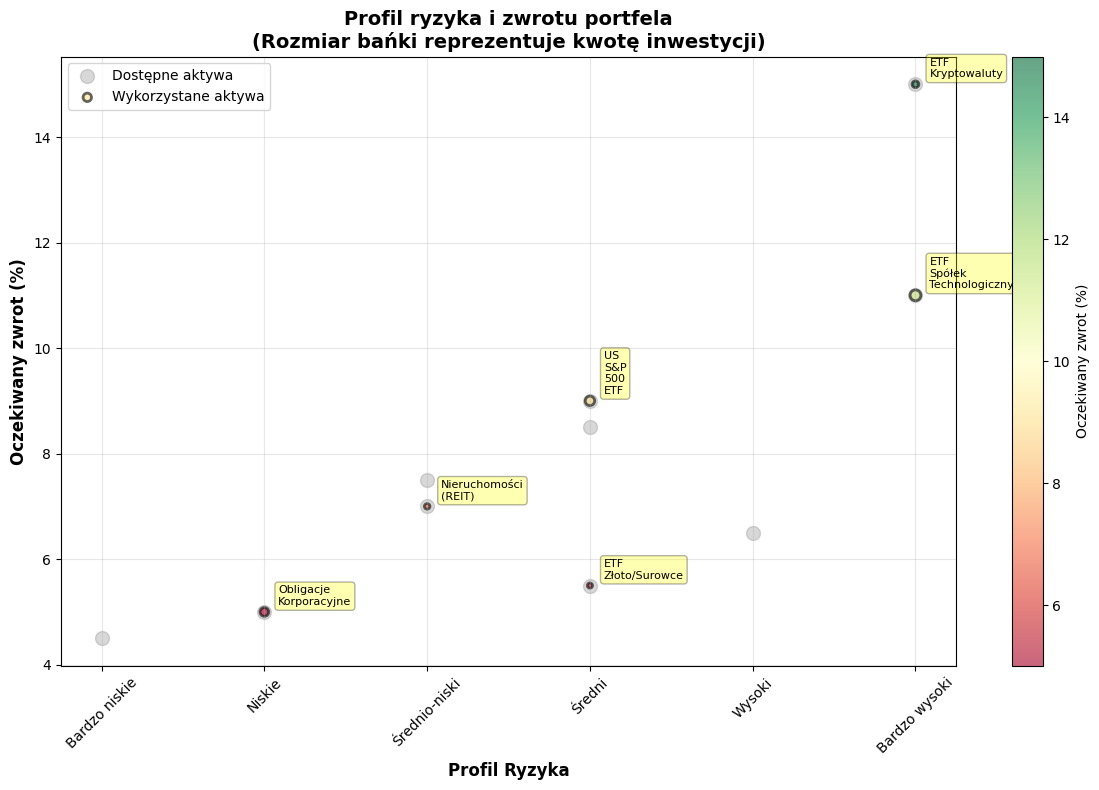

In [11]:
if result.success:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.scatter(risk_levels, expected_returns, s=100, alpha=0.3, c='gray', label='Dostępne aktywa')
    
    # Plot allocated assets (highlighted)
    allocated_mask = optimal_allocation > 0.01
    sizes = optimal_allocation[allocated_mask] / 500  # Scale for visualization
    
    scatter = ax.scatter(
        risk_levels[allocated_mask],
        expected_returns[allocated_mask],
        s=sizes,
        alpha=0.6,
        c=expected_returns[allocated_mask],
        cmap='RdYlGn',
        edgecolors='black',
        linewidth=2,
        label='Wykorzystane aktywa'
    )
    
    for i in range(n):
        if optimal_allocation[i] > 0.01:
            ax.annotate(
                assets[i].replace(' ', '\n'),
                (risk_levels[i], expected_returns[i]),
                xytext=(10, 5),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
            )
    
    ax.set_xlabel('Profil Ryzyka', fontsize=12, fontweight='bold')
    ax.set_ylabel('Oczekiwany zwrot (%)', fontsize=12, fontweight='bold')
    ax.set_title('Profil ryzyka i zwrotu portfela\n(Rozmiar bańki reprezentuje kwotę inwestycji)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(6))
    ax.set_xticklabels(['Bardzo niskie', 'Niskie', 'Średnio-niski', 'Średni', 'Wysoki', 'Bardzo wysoki'], rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Oczekiwany zwrot (%)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## Wnioski

Ten przykład pokazuje, jak programowanie liniowe można zastosować do rzeczywistych decyzji inwestycyjnych. Optymalne rozwiązanie:

1. **Maksymalizacja oczekiwanych stóp zwrotu** przy jednoczesnym spełnieniu wszystkich ograniczeń ryzyka i dywersyfikacji
2. **Równowaga ryzyka i zysku** poprzez inwestowanie w mieszankę aktywów o różnym poziomie ryzyka
3. **Zapewnienie odpowiedniej dywersyfikacji** w różnych sektorach, regionach geograficznych i klasach aktywów
4. **Spełnienie preferencji klientów** w zakresie inwestycji ESG, ochrony przed inflacją i płynności
5. **Osiągnięcie docelowej stopy zwrotu** na poziomie co najmniej 10% rocznie

Główne zalety tego podejścia:
- **Obiektywna optymalizacja** zamiast subiektywnych decyzji
- **Spełnienie ograniczeń** zapewnia spełnienie wszystkich wymagań
- **Powtarzalność** i możliwość łatwej aktualizacji o nowe dane
- **Skalowalność** do portfeli o znacznie większej liczbie aktywów

Ograniczenia:
- Zakłada, że ​​oczekiwane stopy zwrotu są dokładne (w rzeczywistości są to szacunki)
- Nie uwzględnia korelacji między aktywami
- Model liniowy może nie uwzględniać wszystkich rzeczywistych uwarunkowań
- Nie bierze pod uwagę kosztów transakcyjnych lub podatków